Author: Anh Nguyen.

Student number: 2052116

This notebook is the training script for the deep learning component of the thesis. It is recommended to run this notebook in a device with GPU.

Mount google drive (skip this cell if you run the notebook on local machine)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader
from torchvision.models import swin_s, Swin_S_Weights
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.optim.lr_scheduler import StepLR
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os

Check device (make sure it's cuda)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Change dataset directory as neccessary

In [ ]:
# Replace with the dataset directory
train_dir = 'drive/MyDrive/Dataset/archive/Training'
test_dir = 'drive/MyDrive/Dataset/archive/Testing'


Establish the pretrained Swin transformer and freeze all weights. Change the classifier to match the number of output classes.

In [ ]:
pretrained_swin = swin_s(weights = 'IMAGENET1K_V1') # Load pretrained swin transformer
pretrained_swin_weights = Swin_S_Weights.DEFAULT
for param in pretrained_swin.parameters(): # Freeze all weights
    param.requires_grad = False

pretrained_swin.head = nn.Sequential(
    nn.Linear(pretrained_swin.head.in_features, 128),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(128,4),
) # Make a new classifier

pretrained_swin.to(device)

Downloading: "https://download.pytorch.org/models/swin_s-5e29d889.pth" to /root/.cache/torch/hub/checkpoints/swin_s-5e29d889.pth
100%|██████████| 190M/190M [00:01<00:00, 163MB/s]


SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttention(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=384, out_features=96, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (1): SwinTransformerBlock(
       

Data augmentation.

 We use the same augmentation steps as the pretrained model since it maintains the data charateristics, allowing the model to learn more from the data. Different augmentation techniques such as rotation and flipping were tested and gave worse test accuracy.

In [ ]:
print(pretrained_swin_weights.transforms())

ImageClassification(
    crop_size=[224]
    resize_size=[246]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


Create data loader for the train, validation and test set. Validation set is taken from 10% of the training set for fair evaluation on the test set.

In [ ]:
train_data = ImageFolder(root = train_dir, transform = pretrained_swin_weights.transforms())
test_data = ImageFolder(root = test_dir, transform = pretrained_swin_weights.transforms())

validation_split = 0.1
dataset_size = len(train_data)
val_size = int(validation_split * dataset_size)
train_size = dataset_size - val_size

# Take 10% of training data as validation data
train_data, val_data = random_split(train_data, [train_size, val_size])

In [ ]:
batch_size = 64
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = False)

Class labels

In [ ]:
classes = test_data.classes
print(classes)

['glioma', 'meningioma', 'notumor', 'pituitary']


Check the input images (change test_loader shuffle value to True if you want to see varying classes)

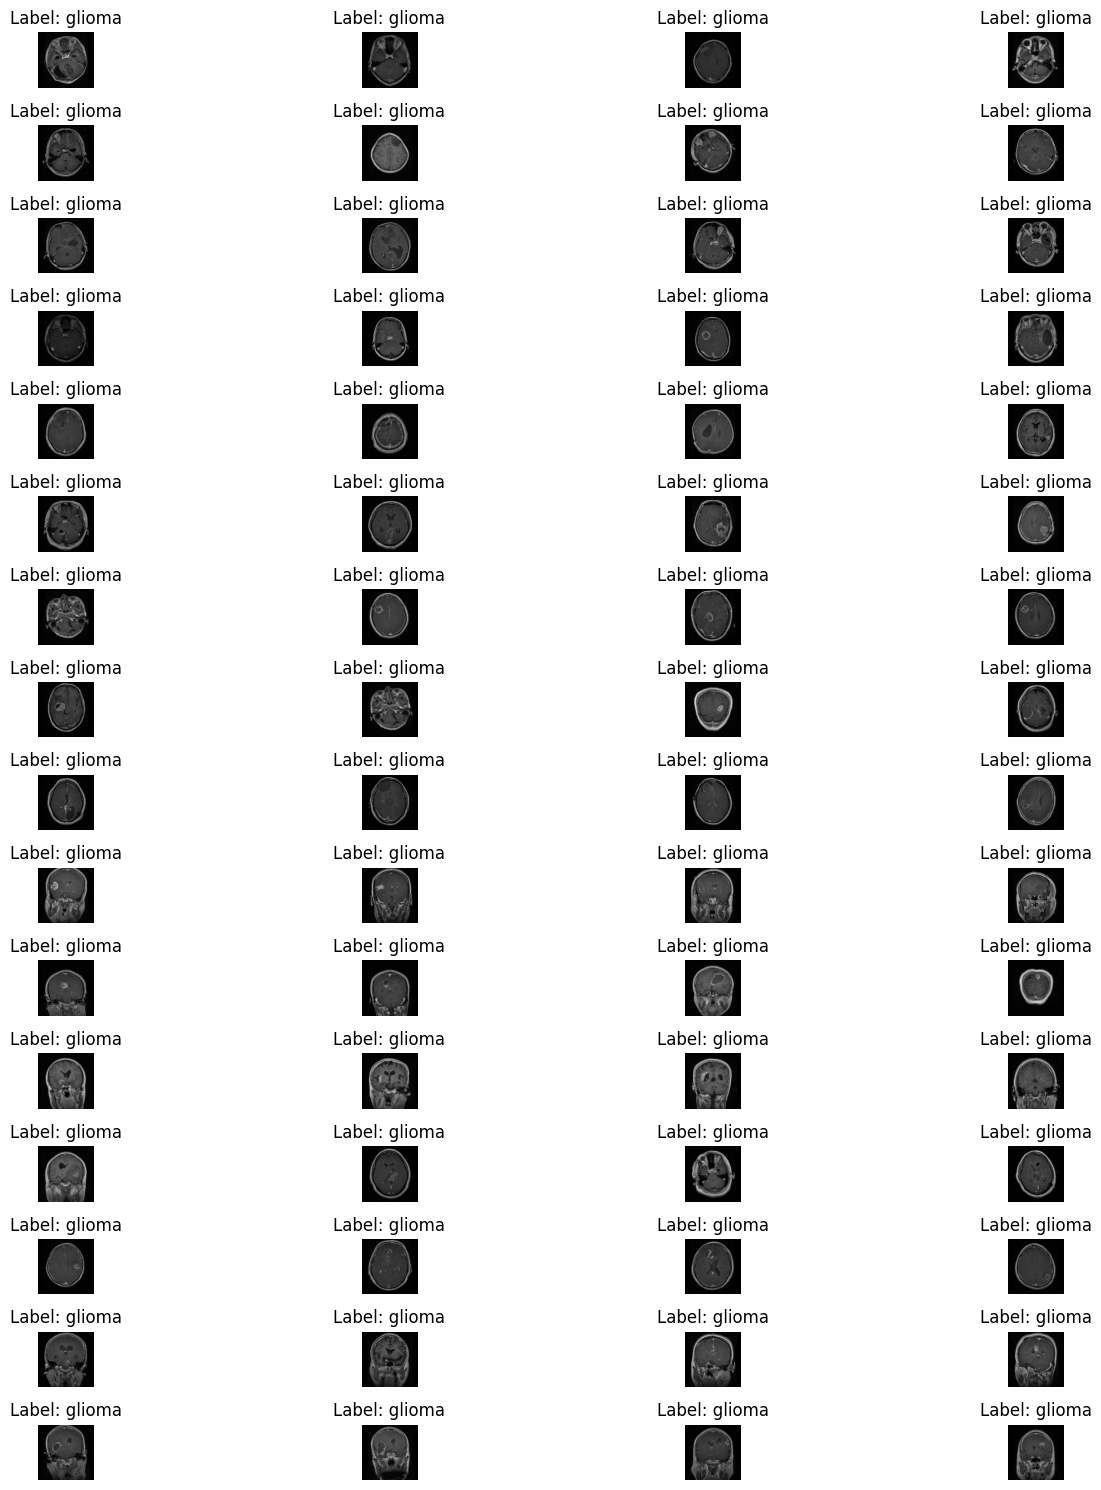

In [ ]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Convert images to numpy arrays and denormalize
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = (images.numpy().transpose((0, 2, 3, 1)) * std + mean).clip(0, 1)

# Create a grid of images
num_images = len(images)
rows = int(np.ceil(num_images / 4))
fig, axes = plt.subplots(rows, 4, figsize=(15, 15))

# Plot images with labels
for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(images[i])
        ax.set_title(f'Label: {train_data.classes[labels[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

Set the criterion, optimizer and learning rate scheduler

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_swin.parameters(), lr = 0.001)
scheduler = StepLR(optimizer, step_size=40, gamma=0.1)

Training script (We store the training and validation accuracy to ensure the model is not overfitting on the training set)

In [ ]:

num_epochs = 90
best_accuracy = 0.0
best_model_weights = None
best_epoch = 0
train_accuracies = []
val_accuracies = []
train_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    # Training phase
    pretrained_swin.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = pretrained_swin(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = correct / total
    train_accuracies.append(train_accuracy)
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}")

    # Validation phase
    pretrained_swin.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = pretrained_swin(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {val_accuracy}")

    # Save the model with the best validation accuracy
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model_weights = pretrained_swin.state_dict()
        best_epoch = epoch
    scheduler.step()


Epoch 1/90, Train Loss: 0.565405876364237, Train Accuracy: 0.7920638008169617
Epoch 1/90, Validation Accuracy: 0.9194395796847635
Epoch 2/90, Train Loss: 0.32510525282518365, Train Accuracy: 0.878428321338261
Epoch 2/90, Validation Accuracy: 0.9211908931698775
Epoch 3/90, Train Loss: 0.274065653115143, Train Accuracy: 0.899046878039292
Epoch 3/90, Validation Accuracy: 0.9387040280210157
Epoch 4/90, Train Loss: 0.2548026990743331, Train Accuracy: 0.9035207158140439
Epoch 4/90, Validation Accuracy: 0.9299474605954466
Epoch 5/90, Train Loss: 0.24278619821056907, Train Accuracy: 0.9076055242170784
Epoch 5/90, Validation Accuracy: 0.9544658493870403
Epoch 6/90, Train Loss: 0.22609839330852768, Train Accuracy: 0.9116903326201128
Epoch 6/90, Validation Accuracy: 0.9404553415061296
Epoch 7/90, Train Loss: 0.20028610564308402, Train Accuracy: 0.9233612137716397
Epoch 7/90, Validation Accuracy: 0.9404553415061296
Epoch 8/90, Train Loss: 0.2029784581175557, Train Accuracy: 0.9212215522271932
Epoc

Save model weight in a .pth file (Specify the folder location)

In [ ]:
# Load the best model weights
torch.save(best_model_weights,'drive/MyDrive/swin_frozenbody_final.pth')
pretrained_swin.load_state_dict(best_model_weights)

<All keys matched successfully>

Check the test set accuracy

In [ ]:
pretrained_swin.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = pretrained_swin(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_accuracy = correct / total
print(f"Epoch {best_epoch+1}/{num_epochs}, Test Accuracy: {val_accuracy}")

Epoch 78/90, Test Accuracy: 0.9740655987795576


Check the training and validation accuracies.

If they are diverging significantly, it means the model is starting to overfit.

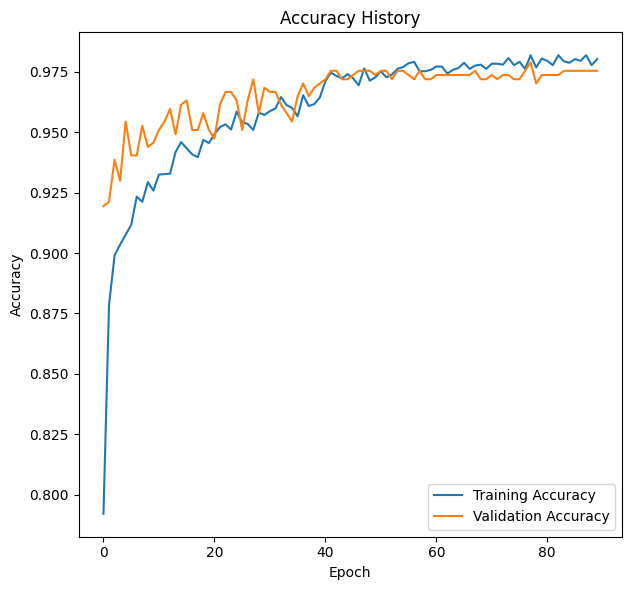

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy History')

plt.tight_layout()
plt.show()